# 라이브러리

In [57]:
import warnings
warnings.filterwarnings('ignore')
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,
    confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score,
    roc_curve, auc, precision_recall_curve, r2_score
)
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Activation, Flatten, Dropout, Reshape,
    Conv1D, MaxPooling1D, Conv2D, MaxPooling2D,
    SimpleRNN, Bidirectional, LSTM, GRU
)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import holidays
from datetime import timedelta

# ML(RandomForest, XGBoost, LightGBM)

## 데이터 전처리 함수

In [2]:
def preprocess_data(file_path):
    df = pd.read_excel(file_path)
    df_gbline = df[df['주운행선'] == '경부선'].copy()
    df_gbline['운행년월'] = pd.to_datetime(df_gbline['운행년월'], format='%Y-%m')
    # Lagged Variable
    df_gbline['승차인원수_T1'] = df_gbline['승차인원수'].shift(1)
    df_gbline['승차인원수_T2'] = df_gbline['승차인원수'].shift(2)
    df_gbline.dropna(subset=['승차인원수_T1', '승차인원수_T2'], inplace=True)

    train_data = df_gbline[(df_gbline['운행년월'] >= '2015-01-01') & (df_gbline['운행년월'] <= '2023-03-31')]
    val_data = df_gbline[(df_gbline['운행년월'] >= '2023-04-01') & (df_gbline['운행년월'] <= '2024-03-31')]
    # VKOSPI(KOSPIV)
    features = ['VKOSPI', '공휴일수', '평일수', '주말수', '명절수', '승차인원수_T1', '승차인원수_T2']

    X_train = train_data[features].dropna()
    Y_train = train_data.loc[X_train.index, '승차인원수']
    X_val = val_data[features].dropna()
    Y_val = val_data.loc[X_val.index, '승차인원수']

    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

    return X_train_scaled, Y_train, X_val_scaled, Y_val, train_data, val_data

## 모델 훈련 및 평가 함수

In [3]:
#랜덤포레스트
def model_rf(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100):
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
        'max_depth': hp.quniform('max_depth', 5, 30, 1),
        'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
        'max_features': hp.uniform('max_features', 0.1, 1.0),
        'bootstrap': hp.choice('bootstrap', [True, False])
    }

    def objective(space):
        clf = RandomForestRegressor(
            n_estimators=int(space['n_estimators']),
            max_depth=int(space['max_depth']),
            min_samples_split=int(space['min_samples_split']),
            min_samples_leaf=int(space['min_samples_leaf']),
            max_features=space['max_features'],
            bootstrap=space['bootstrap'],
            random_state=0
        )
        clf.fit(X_train_scaled, Y_train)
        pred = clf.predict(X_val_scaled)
        mae = mean_absolute_error(Y_val, pred)
        return {'loss': mae, 'status': STATUS_OK}

    trials = Trials()
    best_hyperparams = fmin(fn=objective,
                            space=space,
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trials=trials)

    best_model = RandomForestRegressor(
        n_estimators=int(best_hyperparams['n_estimators']),
        max_depth=int(best_hyperparams['max_depth']),
        min_samples_split=int(best_hyperparams['min_samples_split']),
        min_samples_leaf=int(best_hyperparams['min_samples_leaf']),
        max_features=best_hyperparams['max_features'],
        bootstrap=best_hyperparams['bootstrap'],
        random_state=0
    )

    best_model.fit(X_train_scaled, Y_train)

    Y_train_pred_best = best_model.predict(X_train_scaled)
    train_r_squared_best = r2_score(Y_train, Y_train_pred_best)
    train_mae_best = mean_absolute_error(Y_train, Y_train_pred_best)
    train_mse_best = mean_squared_error(Y_train, Y_train_pred_best)
    train_mape_best = np.mean(np.abs((Y_train - Y_train_pred_best) / Y_train)) * 100

    Y_val_pred_best = best_model.predict(X_val_scaled)
    val_r_squared_best = r2_score(Y_val, Y_val_pred_best)
    val_mae_best = mean_absolute_error(Y_val, Y_val_pred_best)
    val_mse_best = mean_squared_error(Y_val, Y_val_pred_best)
    val_mape_best = np.mean(np.abs((Y_val - Y_val_pred_best) / Y_val)) * 100

    results = {
        'best_hyperparams': best_hyperparams,
        'train_metrics': {
            'r_squared': train_r_squared_best,
            'mae': train_mae_best,
            'mse': train_mse_best,
            'mape': train_mape_best
        },
        'val_metrics': {
            'r_squared': val_r_squared_best,
            'mae': val_mae_best,
            'mse': val_mse_best,
            'mape': val_mape_best
        }
    }
    return best_model, results

#XGB
def model_xgb(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100):
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
        'max_depth': hp.quniform('max_depth', 3, 15, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
        'subsample': hp.uniform('subsample', 0.7, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
        'gamma': hp.uniform('gamma', 0, 0.5),
        'reg_alpha': hp.uniform('reg_alpha', 0, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 0, 1.0)
    }

    def objective(space):
        clf = xgb.XGBRegressor(
            n_estimators=int(space['n_estimators']),
            max_depth=int(space['max_depth']),
            learning_rate=space['learning_rate'],
            subsample=space['subsample'],
            colsample_bytree=space['colsample_bytree'],
            gamma=space['gamma'],
            reg_alpha=space['reg_alpha'],
            reg_lambda=space['reg_lambda'],
            random_state=0
        )
        clf.fit(X_train_scaled, Y_train)
        pred = clf.predict(X_val_scaled)
        mae = mean_absolute_error(Y_val, pred)
        return {'loss': mae, 'status': STATUS_OK}

    trials = Trials()
    best_hyperparams = fmin(fn=objective,
                            space=space,
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trials=trials)

    best_model = xgb.XGBRegressor(
        n_estimators=int(best_hyperparams['n_estimators']),
        max_depth=int(best_hyperparams['max_depth']),
        learning_rate=best_hyperparams['learning_rate'],
        subsample=best_hyperparams['subsample'],
        colsample_bytree=best_hyperparams['colsample_bytree'],
        gamma=best_hyperparams['gamma'],
        reg_alpha=best_hyperparams['reg_alpha'],
        reg_lambda=best_hyperparams['reg_lambda'],
        random_state=0
    )

    best_model.fit(X_train_scaled, Y_train)

    Y_train_pred_best = best_model.predict(X_train_scaled)
    train_r_squared_best = r2_score(Y_train, Y_train_pred_best)
    train_mae_best = mean_absolute_error(Y_train, Y_train_pred_best)
    train_mse_best = mean_squared_error(Y_train, Y_train_pred_best)
    train_mape_best = np.mean(np.abs((Y_train - Y_train_pred_best) / Y_train)) * 100

    Y_val_pred_best = best_model.predict(X_val_scaled)
    val_r_squared_best = r2_score(Y_val, Y_val_pred_best)
    val_mae_best = mean_absolute_error(Y_val, Y_val_pred_best)
    val_mse_best = mean_squared_error(Y_val, Y_val_pred_best)
    val_mape_best = np.mean(np.abs((Y_val - Y_val_pred_best) / Y_val)) * 100

    results = {
        'best_hyperparams': best_hyperparams,
        'train_metrics': {
            'r_squared': train_r_squared_best,
            'mae': train_mae_best,
            'mse': train_mse_best,
            'mape': train_mape_best
        },
        'val_metrics': {
            'r_squared': val_r_squared_best,
            'mae': val_mae_best,
            'mse': val_mse_best,
            'mape': val_mape_best
        }
    }
    return best_model, results

#LightGBM
def model_lightgbm(X_train_scaled, Y_train, X_val_scaled, Y_val):
    # LightGBM 모델 초기화
    lgb_model = lgb.LGBMRegressor(random_state=0)

    # 모델 훈련
    lgb_model.fit(X_train_scaled, Y_train)

    # 훈련 데이터 예측
    Y_train_pred_lgb = lgb_model.predict(X_train_scaled)
    train_r_squared_lgb = r2_score(Y_train, Y_train_pred_lgb)
    train_mae_lgb = mean_absolute_error(Y_train, Y_train_pred_lgb)
    train_mse_lgb = mean_squared_error(Y_train, Y_train_pred_lgb)
    train_mape_lgb = np.mean(np.abs((Y_train - Y_train_pred_lgb) / Y_train)) * 100

    # 검증 데이터 예측
    Y_val_pred_lgb = lgb_model.predict(X_val_scaled)
    val_r_squared_lgb = r2_score(Y_val, Y_val_pred_lgb)
    val_mae_lgb = mean_absolute_error(Y_val, Y_val_pred_lgb)
    val_mse_lgb = mean_squared_error(Y_val, Y_val_pred_lgb)
    val_mape_lgb = np.mean(np.abs((Y_val - Y_val_pred_lgb) / Y_val)) * 100

    results = {
        'train_metrics': {
            'r_squared': train_r_squared_lgb,
            'mae': train_mae_lgb,
            'mse': train_mse_lgb,
            'mape': train_mape_lgb
        },
        'val_metrics': {
            'r_squared': val_r_squared_lgb,
            'mae': val_mae_lgb,
            'mse': val_mse_lgb,
            'mape': val_mape_lgb
        }
    }
    return lgb_model, results

## 시각화 함수

In [4]:
def plot_results(train_data, val_data, Y_train, Y_train_pred, Y_val, Y_val_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['운행년월'], Y_train, label='Actual', color='blue')
    plt.plot(train_data['운행년월'], Y_train_pred, label='Predicted', color='orange')
    plt.title('Train')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(val_data['운행년월'], Y_val, label='Actual', color='blue')
    plt.plot(val_data['운행년월'], Y_val_pred, label='Predicted', color='orange')
    plt.title('Val')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

# RandomForest

100%|██████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27trial/s, best loss: 104863.42981770802]
The best hyperparameters :  

{'bootstrap': 1, 'max_depth': 23.0, 'max_features': 0.8141690353209993, 'min_samples_leaf': 2.0, 'min_samples_split': 6.0, 'n_estimators': 160.0}
Random Forest(Train):
R-squared: 0.92
MAE: 127387.00
MSE: 37225747030.71
MAPE: 5.87%

Random Forest(Val):
R-squared: -0.43
MAE: 139983.88
MSE: 25643995313.06
MAPE: 4.08%


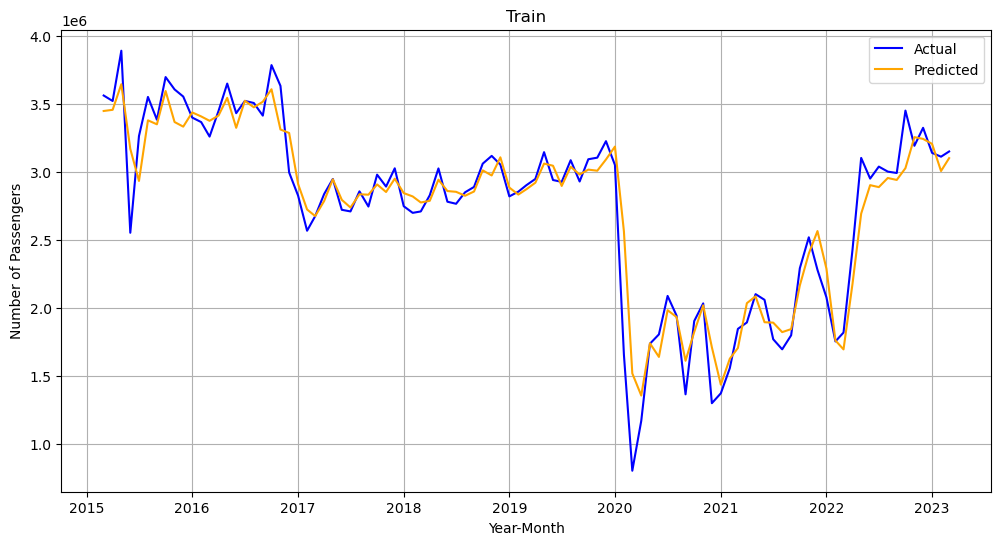

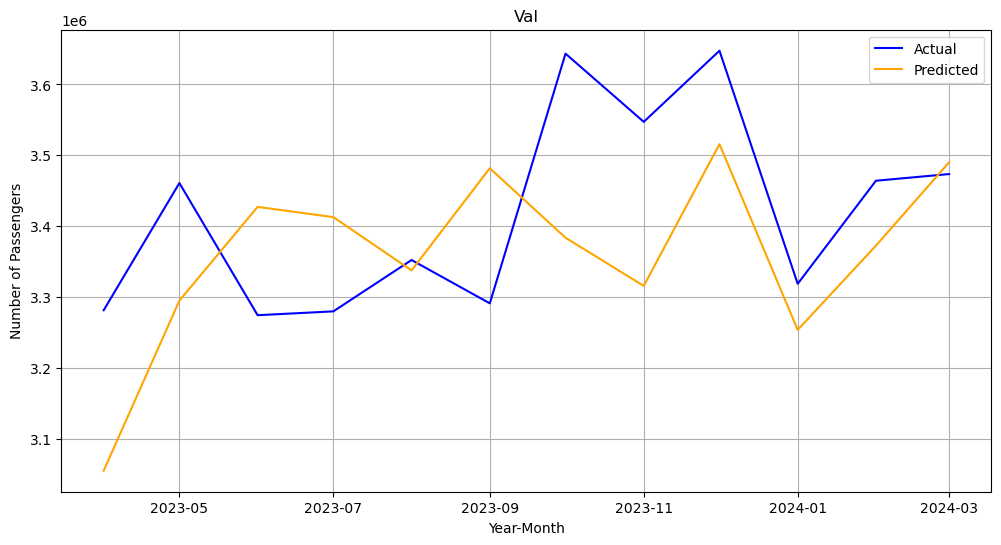

In [5]:
file_path = r"C:\Users\james\DATA_LAB\KTX_Forecasting\data\ktx_20240720.xlsx"
X_train_scaled, Y_train, X_val_scaled, Y_val, train_data, val_data = preprocess_data(file_path)

# RandomForest 모델 평가
best_rf_model, rf_results = model_rf(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100)
print("The best hyperparameters : ", "\n")
print(rf_results['best_hyperparams'])

print('Random Forest(Train):')
print(f"R-squared: {rf_results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {rf_results['train_metrics']['mae']:.2f}")
print(f"MSE: {rf_results['train_metrics']['mse']:.2f}")
print(f"MAPE: {rf_results['train_metrics']['mape']:.2f}%")
print()
print('Random Forest(Val):')
print(f"R-squared: {rf_results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {rf_results['val_metrics']['mae']:.2f}")
print(f"MSE: {rf_results['val_metrics']['mse']:.2f}")
print(f"MAPE: {rf_results['val_metrics']['mape']:.2f}%")

Y_train_pred_rf = best_rf_model.predict(X_train_scaled)
Y_val_pred_rf = best_rf_model.predict(X_val_scaled)

plot_results(train_data, val_data, Y_train, Y_train_pred_rf, Y_val, Y_val_pred_rf)

# XGBoost

100%|██████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.22trial/s, best loss: 83697.9375]
The best hyperparameters :  

{'colsample_bytree': 0.9413543356046226, 'gamma': 0.3530087752225537, 'learning_rate': 0.2495047112177011, 'max_depth': 3.0, 'n_estimators': 200.0, 'reg_alpha': 0.4174402980035365, 'reg_lambda': 0.6307924851794112, 'subsample': 0.8317738837036501}
XGBoost(Train):
R-squared: 1.00
MAE: 1395.71
MSE: 2992167.80
MAPE: 0.05%

XGBoost(Val):
R-squared: 0.24
MAE: 83697.94
MSE: 13695118007.17
MAPE: 2.48%


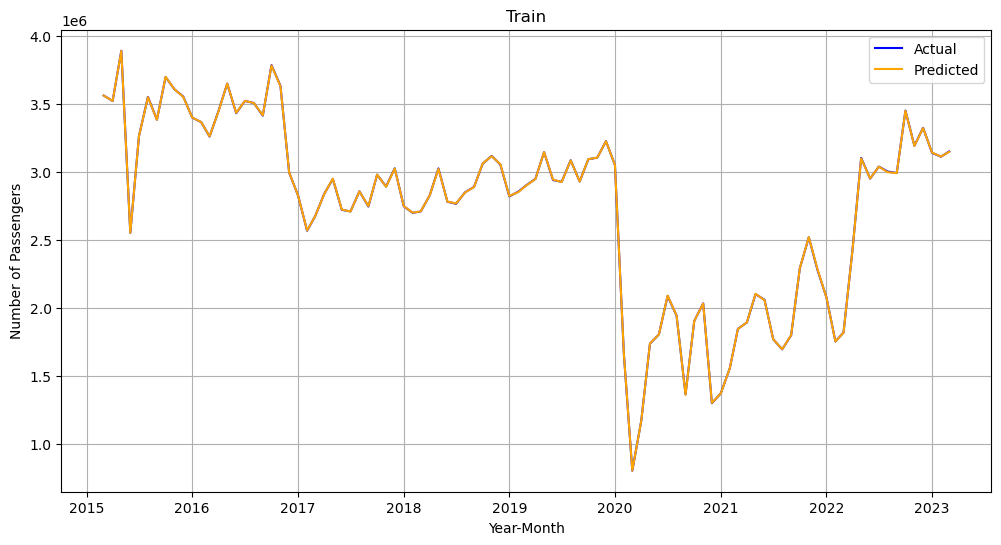

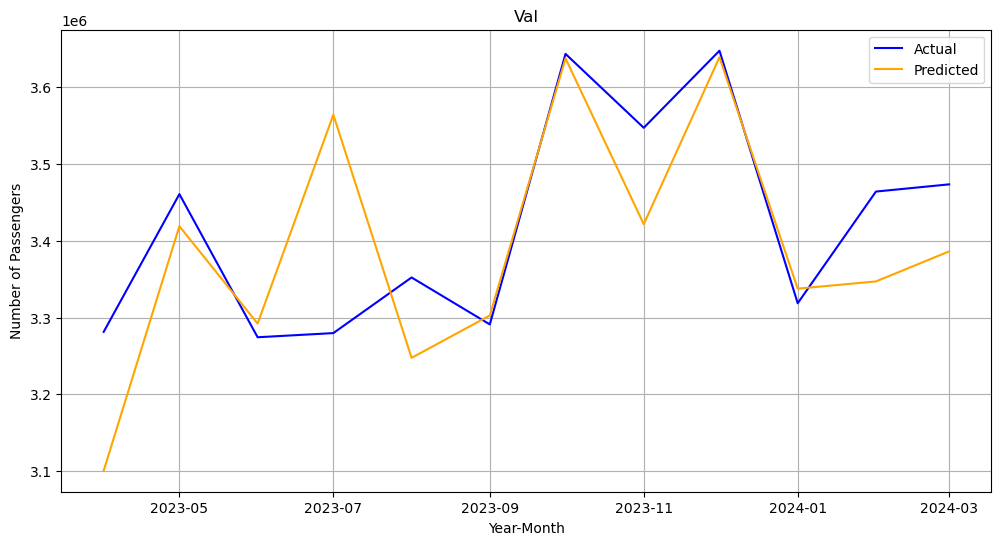

In [6]:
# XGBoost 모델 평가
best_xgb_model, xgb_results = model_xgb(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100)
print("The best hyperparameters : ", "\n")
print(xgb_results['best_hyperparams'])

print('XGBoost(Train):')
print(f"R-squared: {xgb_results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {xgb_results['train_metrics']['mae']:.2f}")
print(f"MSE: {xgb_results['train_metrics']['mse']:.2f}")
print(f"MAPE: {xgb_results['train_metrics']['mape']:.2f}%")
print()
print('XGBoost(Val):')
print(f"R-squared: {xgb_results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {xgb_results['val_metrics']['mae']:.2f}")
print(f"MSE: {xgb_results['val_metrics']['mse']:.2f}")
print(f"MAPE: {xgb_results['val_metrics']['mape']:.2f}%")

Y_train_pred_xgb = best_xgb_model.predict(X_train_scaled)
Y_val_pred_xgb = best_xgb_model.predict(X_val_scaled)

plot_results(train_data, val_data, Y_train, Y_train_pred_xgb, Y_val, Y_val_pred_xgb)
#{'colsample_bytree': 0.8922607113389976, 'gamma': 0.29202225637784096, 'learning_rate': 0.10486928608249282, 'max_depth': 6.0, 'n_estimators': 280.0, 'reg_alpha': 0.9413775711280722, 'reg_lambda': 0.8990091066271554, 'subsample': 0.8712113355918811}

# LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 6
[LightGBM] [Info] Start training from score 2752700.144330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

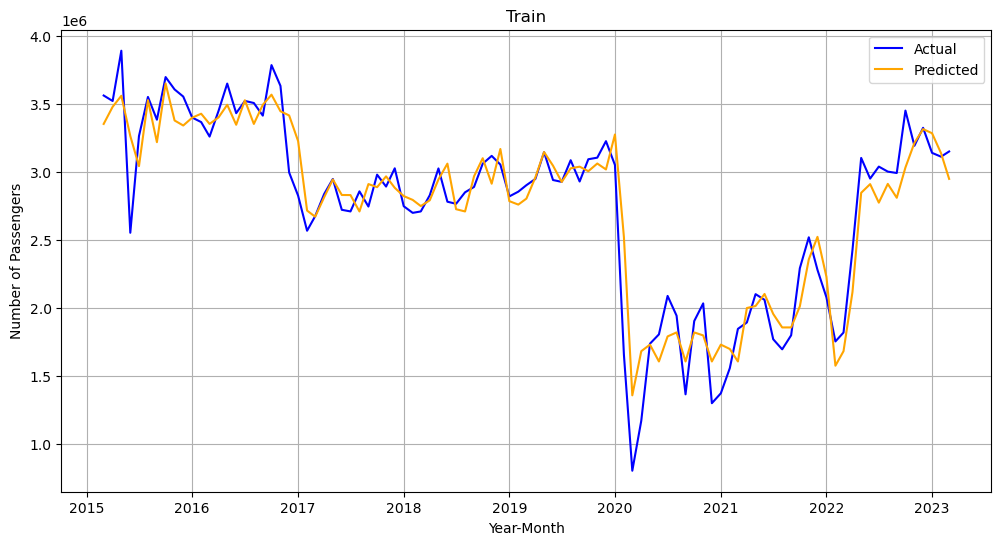

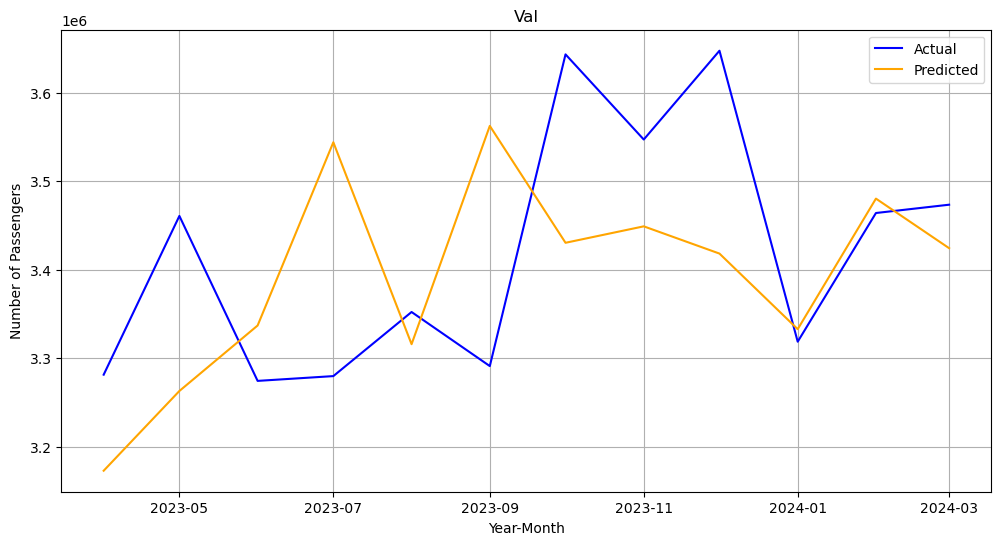

In [7]:
best_lgb_model, lgb_results = model_lightgbm(X_train_scaled, Y_train, X_val_scaled, Y_val)
print("LightGBM(Train):")
print(f"R-squared: {lgb_results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {lgb_results['train_metrics']['mae']:.2f}")
print(f"MSE: {lgb_results['train_metrics']['mse']:.2f}")
print(f"MAPE: {lgb_results['train_metrics']['mape']:.2f}%")
print()
print("LightGBM(Val):")
print(f"R-squared: {lgb_results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {lgb_results['val_metrics']['mae']:.2f}")
print(f"MSE: {lgb_results['val_metrics']['mse']:.2f}")
print(f"MAPE: {lgb_results['val_metrics']['mape']:.2f}%")

Y_train_pred_lgb = best_lgb_model.predict(X_train_scaled)
Y_val_pred_lgb = best_lgb_model.predict(X_val_scaled)

plot_results(train_data, val_data, Y_train, Y_train_pred_lgb, Y_val, Y_val_pred_lgb)


# DL(LSTM, GRU, CNN, RNN)

## 전처리

In [18]:
def preprocessing_dl(df):
    # 시간정보 datetime 형식으로 변환
    if '운행년월' in df.columns:
        df['DateTime'] = pd.to_datetime(df['운행년월'])
    
    #index 시간정보로 변경
    if df.index.dtype == 'int64':
        df.set_index('DateTime', inplace=True)

    duplicate_index = df.index[df.index.duplicated()]

    # 중복 인덱스 제거
    df = df[~df.index.duplicated(keep='first')]

    # 결측값 처리 
    df.fillna(method='ffill', inplace=True)
    
    # 월 단위로 시간정보 설정
    df = df.asfreq('MS')
    
    # Lagged Variables 추가
    df['승차인원수_T1'] = df['승차인원수'].shift(1)
    df['승차인원수_T2'] = df['승차인원수'].shift(2)
    df.dropna(subset=['승차인원수_T1', '승차인원수_T2'], inplace=True)
    
    # Train & Val 데이터 분할
    df_train = df.loc[df.index >= '2015-01-01']
    df_train = df_train.loc[df_train.index < '2023-04-01']
    df_val = df.loc[df.index >= '2023-04-01']
    
    # 종속변수와 독립변수 결정
    Y_colname = ['승차인원수']
    X_colname = ['VKOSPI', '공휴일수', '평일수', '주말수', '명절수','승차인원수_T1','승차인원수_T2']
    
    # X_train, Y_train, X_test, Y_test 분할
    Y_train = df_train[Y_colname]
    X_train = df_train[X_colname]
    Y_val = df_val[Y_colname]
    X_val = df_val[X_colname]
    
    return X_train, X_val, Y_train, Y_val

# 파일 경로 및 불러오기
file_path = r"C:\Users\james\DATA_LAB\KTX_Forecasting\data\ktx_20240720.xlsx"
df = pd.read_excel(file_path)

# 데이터 전처리
X_train, X_val, Y_train, Y_val = preprocessing_dl(df)

# 데이터 스케일링
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_val_scaled = scaler_Y.transform(Y_val)
    
print('---------------Train----------------')
print('Normalized X: ', X_train_scaled.shape, X_train_scaled.min(), X_train_scaled.max())
print('Normalized Y: ', Y_train_scaled.shape, Y_train_scaled.min(), Y_train_scaled.max())
print('----------------Test----------------')
print('Normalized X: ', X_val_scaled.shape, X_val_scaled.min(), X_val_scaled.max())
print('Normalized Y: ', Y_val_scaled.shape, Y_val_scaled.min(), Y_val_scaled.max())

---------------Train----------------
Normalized X:  (97, 7) 0.0 1.0
Normalized Y:  (97, 1) 0.0 1.0
----------------Test----------------
Normalized X:  (12, 7) 0.0 1.0
Normalized Y:  (12, 1) 0.799528311800515 0.9201945471317976


## 하이퍼파라미터

In [21]:
# 하이퍼파라미터
tf.random.set_seed(1)
KERNEL_SIZE = 3
STRIDE = 1
POOL_SIZE = 2
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'linear'
REGULARIZER = regularizers.l2(0.01)
DROPOUT_RATIO = 0.25
LOSS = 'mse'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['mse']
BATCH_SIZE = 64
EPOCHS = 100
VERBOSE = 0

## 시각화 함수

In [53]:
def plot_results2(train_data, val_data, Y_train, Y_train_pred, Y_val, Y_val_pred):
    # Train 데이터 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index[time_step:], Y_train, label='Actual', color='blue')
    plt.plot(train_data.index[time_step:], Y_train_pred, label='Pred', color='orange')
    plt.title('Train')
    plt.xlabel('DateTime')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Val 데이터 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(val_data.index[time_step:], Y_val, label='Actual', color='blue')
    plt.plot(val_data.index[time_step:], Y_val_pred, label='Pred', color='orange')
    plt.title('Val')
    plt.xlabel('DateTime')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

# LSTM

In [22]:
def reshape_for_lstm(X, Y, time_step):
    X_reshaped = []
    Y_reshaped = []
    for i in range(len(X) - time_step):
        X_reshaped.append(X[i:i + time_step])
        Y_reshaped.append(Y[i + time_step])
    return np.array(X_reshaped), np.array(Y_reshaped)

time_step = 3

# Train 재구성
X_train_lstm, Y_train_lstm = reshape_for_lstm(X_train_scaled, Y_train_scaled, time_step)

# Val 재구성
X_val_lstm, Y_val_lstm = reshape_for_lstm(X_val_scaled, Y_val_scaled, time_step)

print("X_train_lstm shape:", X_train_lstm.shape)
print("Y_train_lstm shape:", Y_train_lstm.shape)
print("X_val_lstm shape:", X_val_lstm.shape)
print("Y_val_lstm shape:", Y_val_lstm.shape)

X_train_lstm shape: (94, 3, 7)
Y_train_lstm shape: (94, 1)
X_val_lstm shape: (9, 3, 7)
Y_val_lstm shape: (9, 1)


In [23]:
# LSTM 모델 정의
#model = Sequential()
#model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train_scaled.shape[1])))
#model.add(LSTM(50, return_sequences=False))
#model.add(Dense(Y_train_scaled.shape[1]))


model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train_scaled.shape[1])))
model.add(Dropout(0.2))
#model.add(LSTM(50, return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(25, return_sequences=False))
model.add(Dropout(0.2))
#model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 컴파일
#model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)

# 모델 요약 출력
model.summary()

# 모델 학습
history = model.fit(X_train_lstm, Y_train_lstm, 
                    epochs=100, 
                    batch_size=64, 
                    validation_data=(X_val_lstm, Y_val_lstm), verbose=2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10),
                               ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1)])

#history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, 
  #                           validation_data=(X_val, Y_val), verbose=2, 
    #                         callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

# 모델 예측
Y_train_pred_lstm = model.predict(X_train_lstm)
Y_val_pred_lstm = model.predict(X_val_lstm)

# 역변환
Y_train_pred = scaler_Y.inverse_transform(Y_train_pred_lstm)
Y_val_pred = scaler_Y.inverse_transform(Y_val_pred_lstm)

Y_train_actual = scaler_Y.inverse_transform(Y_train_lstm)
Y_val_actual = scaler_Y.inverse_transform(Y_val_lstm)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 50)             11600     
                                                                 
 dropout (Dropout)           (None, 3, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 25)                7600      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 19226 (75.10 KB)
Trainable params: 19226 (75.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100

2/2 -

LSTM(Train):
R-squared: 0.30
MAE: 361569.18
MSE: 303442936328.21
MAPE: 19.83%

LSTM(Val):
R-squared: -1.05
MAE: 157726.19
MSE: 38132148856.03
MAPE: 4.49%


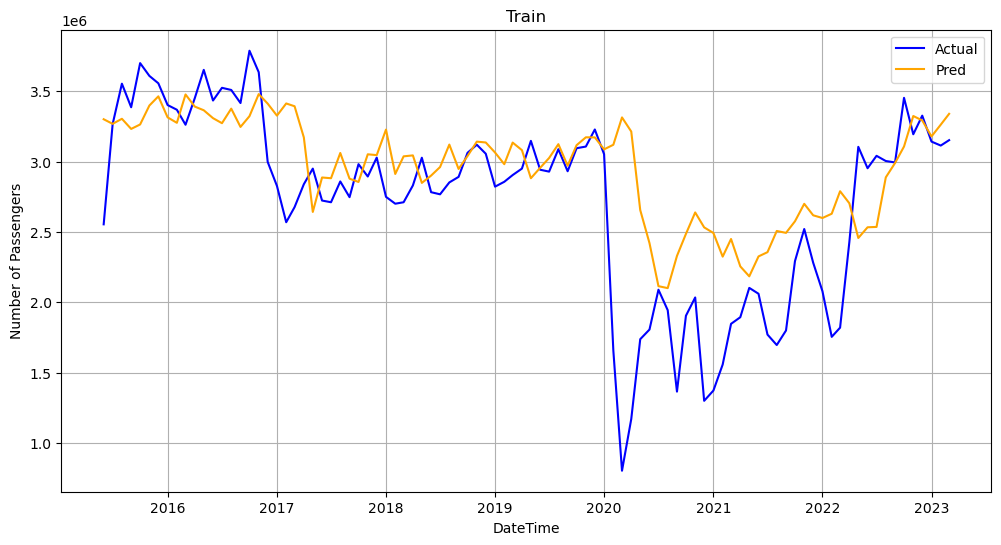

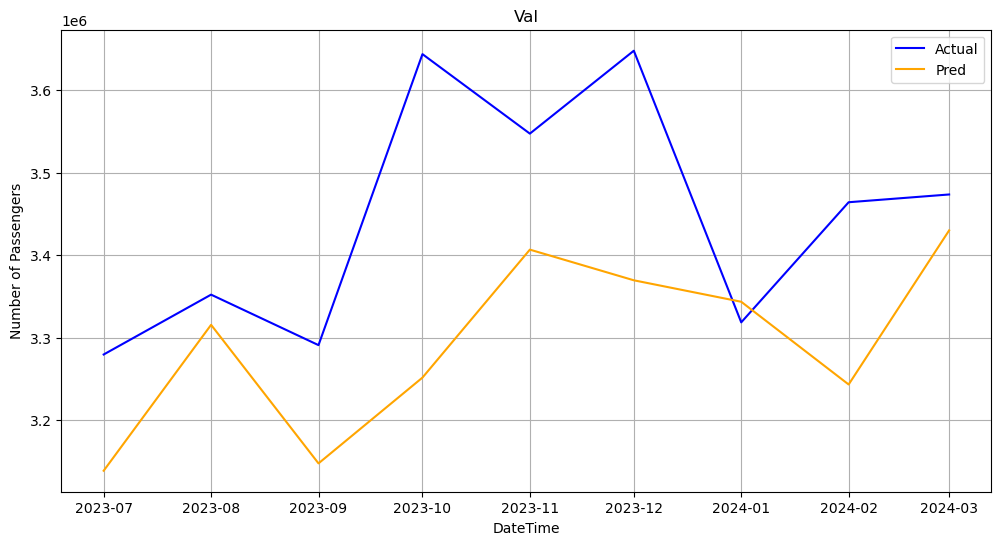

In [54]:
# 지표 계산
train_r_squared = r2_score(Y_train_actual, Y_train_pred)
train_mae = mean_absolute_error(Y_train_actual, Y_train_pred)
train_mse = mean_squared_error(Y_train_actual, Y_train_pred)
train_mape = np.mean(np.abs((Y_train_actual - Y_train_pred) / Y_train_actual)) * 100

val_r_squared = r2_score(Y_val_actual, Y_val_pred)
val_mae = mean_absolute_error(Y_val_actual, Y_val_pred)
val_mse = mean_squared_error(Y_val_actual, Y_val_pred)
val_mape = np.mean(np.abs((Y_val_actual - Y_val_pred) / Y_val_actual)) * 100

lstm_results = {
    'train_metrics': {
        'r_squared': train_r_squared,
        'mae': train_mae,
        'mse': train_mse,
        'mape': train_mape
    },
    'val_metrics': {
        'r_squared': val_r_squared,
        'mae': val_mae,
        'mse': val_mse,
        'mape': val_mape
    }
}

print('LSTM(Train):')
print(f"R-squared: {lstm_results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {lstm_results['train_metrics']['mae']:.2f}")
print(f"MSE: {lstm_results['train_metrics']['mse']:.2f}")
print(f"MAPE: {lstm_results['train_metrics']['mape']:.2f}%")
print()
print('LSTM(Val):')
print(f"R-squared: {lstm_results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {lstm_results['val_metrics']['mae']:.2f}")
print(f"MSE: {lstm_results['val_metrics']['mse']:.2f}")
print(f"MAPE: {lstm_results['val_metrics']['mape']:.2f}%")

# 시각화
plot_results2(X_train, Y_val, Y_train_actual, Y_train_pred, Y_val_actual, Y_val_pred)

# GRU

In [40]:
# GRU 모델 정의
model_gru = Sequential()
model_gru.add(GRU(50, return_sequences=True, input_shape=(time_step, X_train_scaled.shape[1])))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(25, return_sequences=False))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(1, activation='linear'))
model_gru.compile(optimizer='adam', loss='mean_squared_error')

model_gru.summary()

# 모델 학습
history_gru = model_gru.fit(X_train_lstm, Y_train_lstm, 
                            epochs=100, 
                            batch_size=64, 
                            validation_data=(X_val_lstm, Y_val_lstm), verbose=2,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=10),
                                       ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1)])

# 모델 예측
Y_train_pred_gru = model_gru.predict(X_train_lstm)
Y_val_pred_gru = model_gru.predict(X_val_lstm)

# 역변환
Y_train_pred_gru = scaler_Y.inverse_transform(Y_train_pred_gru)
Y_val_pred_gru = scaler_Y.inverse_transform(Y_val_pred_gru)

Y_train_actual = scaler_Y.inverse_transform(Y_train_lstm)
Y_val_actual = scaler_Y.inverse_transform(Y_val_lstm)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 3, 50)             8850      
                                                                 
 dropout_18 (Dropout)        (None, 3, 50)             0         
                                                                 
 gru_3 (GRU)                 (None, 25)                5775      
                                                                 
 dropout_19 (Dropout)        (None, 25)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 26        
                                                                 
Total params: 14651 (57.23 KB)
Trainable params: 14651 (57.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
2/2 - 

GRU(Train):
R-squared: 0.43
MAE: 344063.27
MSE: 247377473403.52
MAPE: 17.65%

GRU(Val):
R-squared: -6.84
MAE: 370798.31
MSE: 145942525624.42
MAPE: 10.69%


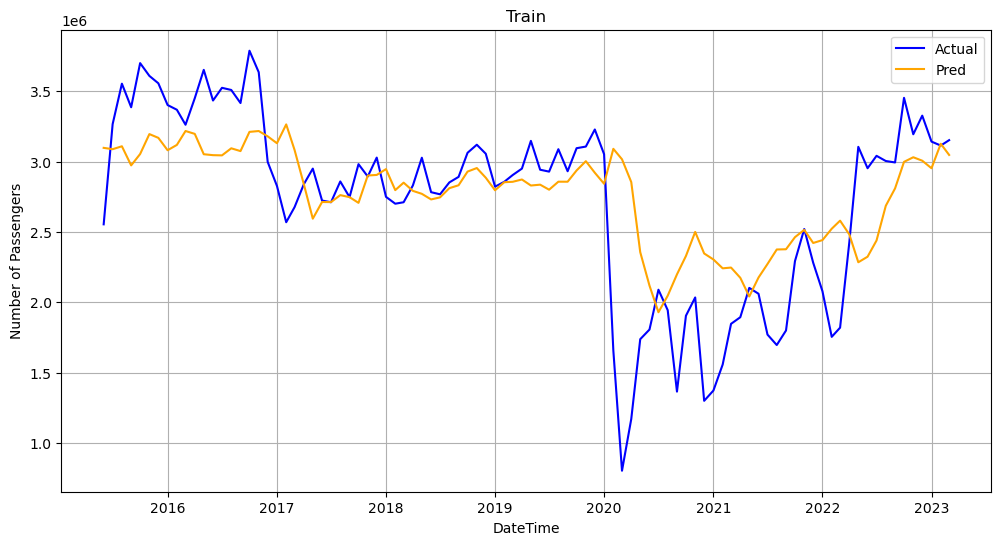

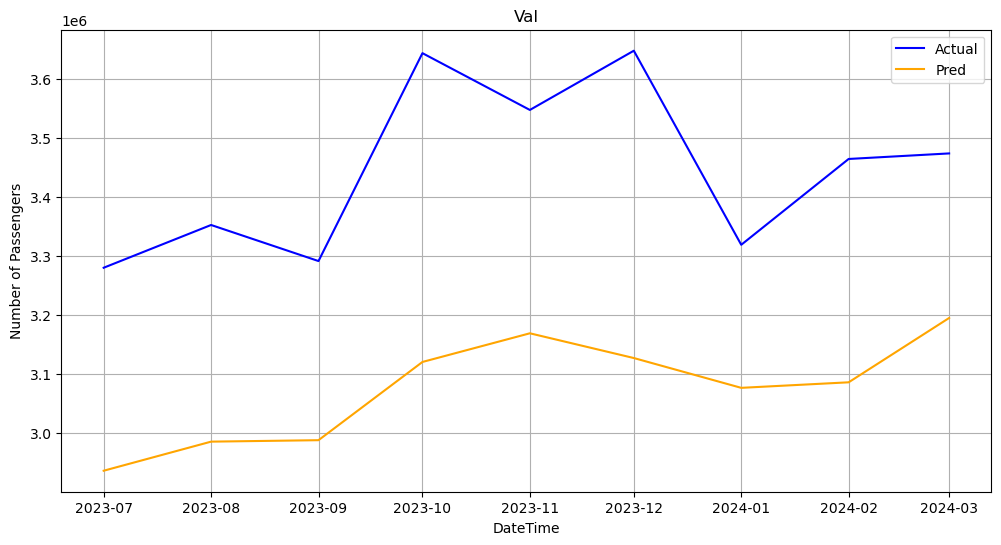

In [55]:
# 지표 계산
train_r_squared_gru = r2_score(Y_train_actual, Y_train_pred_gru)
train_mae_gru = mean_absolute_error(Y_train_actual, Y_train_pred_gru)
train_mse_gru = mean_squared_error(Y_train_actual, Y_train_pred_gru)
train_mape_gru = np.mean(np.abs((Y_train_actual - Y_train_pred_gru) / Y_train_actual)) * 100

val_r_squared_gru = r2_score(Y_val_actual, Y_val_pred_gru)
val_mae_gru = mean_absolute_error(Y_val_actual, Y_val_pred_gru)
val_mse_gru = mean_squared_error(Y_val_actual, Y_val_pred_gru)
val_mape_gru = np.mean(np.abs((Y_val_actual - Y_val_pred_gru) / Y_val_actual)) * 100

gru_results = {
    'train_metrics': {
        'r_squared': train_r_squared_gru,
        'mae': train_mae_gru,
        'mse': train_mse_gru,
        'mape': train_mape_gru
    },
    'val_metrics': {
        'r_squared': val_r_squared_gru,
        'mae': val_mae_gru,
        'mse': val_mse_gru,
        'mape': val_mape_gru
    }
}
print('GRU(Train):')
print(f"R-squared: {gru_results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {gru_results['train_metrics']['mae']:.2f}")
print(f"MSE: {gru_results['train_metrics']['mse']:.2f}")
print(f"MAPE: {gru_results['train_metrics']['mape']:.2f}%")
print()
print('GRU(Val):')
print(f"R-squared: {gru_results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {gru_results['val_metrics']['mae']:.2f}")
print(f"MSE: {gru_results['val_metrics']['mse']:.2f}")
print(f"MAPE: {gru_results['val_metrics']['mape']:.2f}%")

# 시각화
plot_results2(X_train, X_val, Y_train_actual, Y_train_pred_gru, Y_val_actual, Y_val_pred_gru)

# CNN

In [42]:
# CNN 모델 정의
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_step, X_train_scaled.shape[1])))
model_cnn.add(Dropout(0.2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(1, activation='linear'))
model_cnn.compile(optimizer='adam', loss='mean_squared_error')

model_cnn.summary()

# 모델 학습
history_cnn = model_cnn.fit(X_train_lstm, Y_train_lstm, 
                            epochs=100, 
                            batch_size=64, 
                            validation_data=(X_val_lstm, Y_val_lstm), verbose=2,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=10),
                                       ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1)])

# 모델 예측
Y_train_pred_cnn = model_cnn.predict(X_train_lstm)
Y_val_pred_cnn = model_cnn.predict(X_val_lstm)

# 역변환
Y_train_pred_cnn = scaler_Y.inverse_transform(Y_train_pred_cnn)
Y_val_pred_cnn = scaler_Y.inverse_transform(Y_val_pred_cnn)

Y_train_actual = scaler_Y.inverse_transform(Y_train_lstm)
Y_val_actual = scaler_Y.inverse_transform(Y_val_lstm)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 1, 64)             1408      
                                                                 
 dropout_20 (Dropout)        (None, 1, 64)             0         
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 50)                3250      
                                                                 
 dropout_21 (Dropout)        (None, 50)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 4709 (18.39 KB)
Trainable params: 4709 (

CNN(Train):
R-squared: 0.34
MAE: 404504.34
MSE: 287150172594.32
MAPE: 19.59%

CNN(Val):
R-squared: -11.99
MAE: 470574.11
MSE: 241792888338.72
MAPE: 13.59%


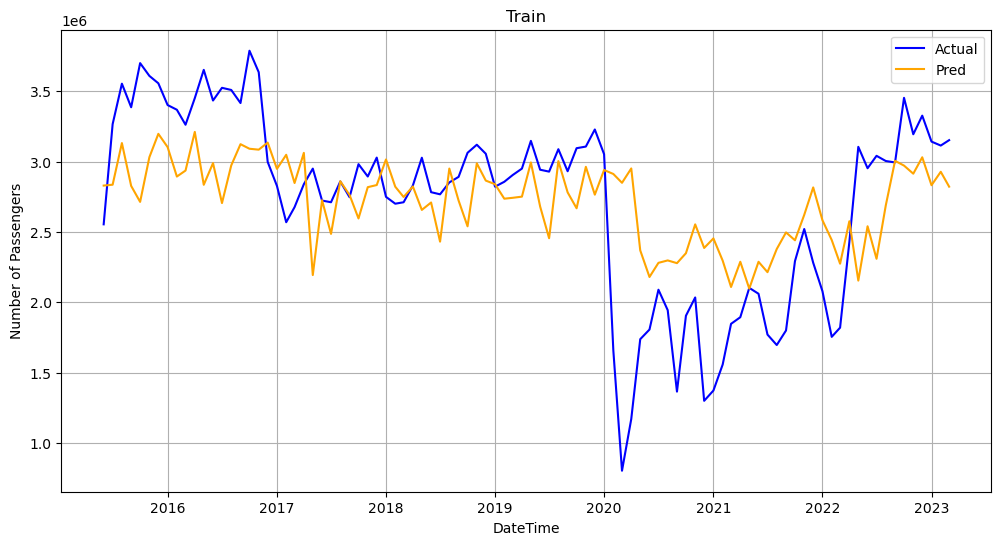

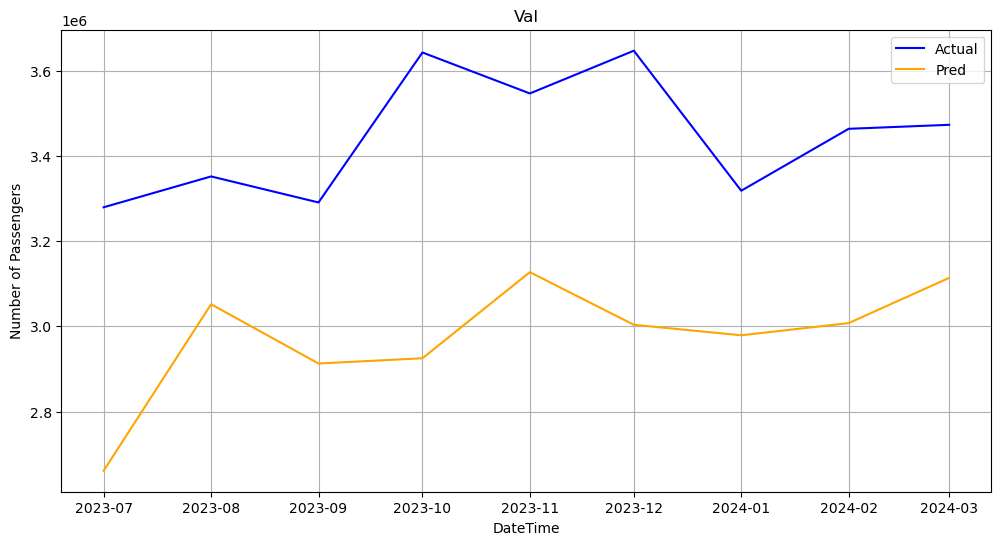

In [56]:
# 지표 계산
train_r_squared_cnn = r2_score(Y_train_actual, Y_train_pred_cnn)
train_mae_cnn = mean_absolute_error(Y_train_actual, Y_train_pred_cnn)
train_mse_cnn = mean_squared_error(Y_train_actual, Y_train_pred_cnn)
train_mape_cnn = np.mean(np.abs((Y_train_actual - Y_train_pred_cnn) / Y_train_actual)) * 100

val_r_squared_cnn = r2_score(Y_val_actual, Y_val_pred_cnn)
val_mae_cnn = mean_absolute_error(Y_val_actual, Y_val_pred_cnn)
val_mse_cnn = mean_squared_error(Y_val_actual, Y_val_pred_cnn)
val_mape_cnn = np.mean(np.abs((Y_val_actual - Y_val_pred_cnn) / Y_val_actual)) * 100

cnn_results = {
    'train_metrics': {
        'r_squared': train_r_squared_cnn,
        'mae': train_mae_cnn,
        'mse': train_mse_cnn,
        'mape': train_mape_cnn
    },
    'val_metrics': {
        'r_squared': val_r_squared_cnn,
        'mae': val_mae_cnn,
        'mse': val_mse_cnn,
        'mape': val_mape_cnn
    }
}

print('CNN(Train):')
print(f"R-squared: {cnn_results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {cnn_results['train_metrics']['mae']:.2f}")
print(f"MSE: {cnn_results['train_metrics']['mse']:.2f}")
print(f"MAPE: {cnn_results['train_metrics']['mape']:.2f}%")
print()
print('CNN(Val):')
print(f"R-squared: {cnn_results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {cnn_results['val_metrics']['mae']:.2f}")
print(f"MSE: {cnn_results['val_metrics']['mse']:.2f}")
print(f"MAPE: {cnn_results['val_metrics']['mape']:.2f}%")

# 시각화 호출
plot_results2(X_train, X_val, Y_train_actual, Y_train_pred_cnn, Y_val_actual, Y_val_pred_cnn)

# RNN

In [45]:
def preprocess_rnn(X, Y):
    X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
    Y_reshaped = Y.reshape((Y.shape[0], 1))
    return X_reshaped, Y_reshaped

X_train_rnn, Y_train_rnn = preprocess_rnn(X_train_scaled, Y_train_scaled)
X_val_rnn, Y_val_rnn = preprocess_rnn(X_val_scaled, Y_val_scaled)

# RNN 모델 생성 함수
def create_rnn(input_shape):
    model = Sequential()
    model.add(SimpleRNN(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# RNN 모델 학습 함수
def model_rnn(X_train, Y_train, X_val, Y_val, epochs=100, batch_size=64):
    input_shape = (X_train.shape[1], X_train.shape[2])
    rnn_model = create_rnn(input_shape)

    history = rnn_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, 
                            validation_data=(X_val, Y_val), verbose=2, 
                            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

    Y_train_pred = rnn_model.predict(X_train)
    Y_val_pred = rnn_model.predict(X_val)

    return rnn_model, Y_train_pred, Y_val_pred, history

# RNN 모델 평가
best_rnn_model, Y_train_pred_rnn, Y_val_pred_rnn, history = model_rnn(X_train_rnn, Y_train_rnn, X_val_rnn, Y_val_rnn, epochs=100, batch_size=64)

# 역변환
Y_train_pred_rnn = scaler_Y.inverse_transform(Y_train_pred_rnn)
Y_val_pred_rnn = scaler_Y.inverse_transform(Y_val_pred_rnn)
Y_train_rnn = scaler_Y.inverse_transform(Y_train_rnn)
Y_val_rnn = scaler_Y.inverse_transform(Y_val_rnn)

Epoch 1/100
2/2 - 6s - loss: 2.1339 - val_loss: 1.3171 - 6s/epoch - 3s/step
Epoch 2/100
2/2 - 0s - loss: 0.6708 - val_loss: 0.3663 - 162ms/epoch - 81ms/step
Epoch 3/100
2/2 - 0s - loss: 0.2682 - val_loss: 0.0723 - 79ms/epoch - 40ms/step
Epoch 4/100
2/2 - 0s - loss: 0.2824 - val_loss: 0.0953 - 90ms/epoch - 45ms/step
Epoch 5/100
2/2 - 0s - loss: 0.4223 - val_loss: 0.1030 - 77ms/epoch - 39ms/step
Epoch 6/100
2/2 - 0s - loss: 0.3649 - val_loss: 0.0580 - 71ms/epoch - 35ms/step
Epoch 7/100
2/2 - 0s - loss: 0.2696 - val_loss: 0.0212 - 72ms/epoch - 36ms/step
Epoch 8/100
2/2 - 0s - loss: 0.1827 - val_loss: 0.0272 - 70ms/epoch - 35ms/step
Epoch 9/100
2/2 - 0s - loss: 0.1548 - val_loss: 0.0640 - 73ms/epoch - 36ms/step
Epoch 10/100
2/2 - 0s - loss: 0.1429 - val_loss: 0.0972 - 68ms/epoch - 34ms/step
Epoch 11/100
2/2 - 0s - loss: 0.1670 - val_loss: 0.1051 - 75ms/epoch - 37ms/step
Epoch 12/100
2/2 - 0s - loss: 0.1306 - val_loss: 0.0823 - 67ms/epoch - 33ms/step
Epoch 13/100
2/2 - 0s - loss: 0.1319 - v

RNN(Train):
R-squared: 0.30
MAE: 361569.18
MSE: 303442936328.21
MAPE: 19.83%

RNN(Val):
R-squared: -1.05
MAE: 157726.19
MSE: 38132148856.03
MAPE: 4.49%


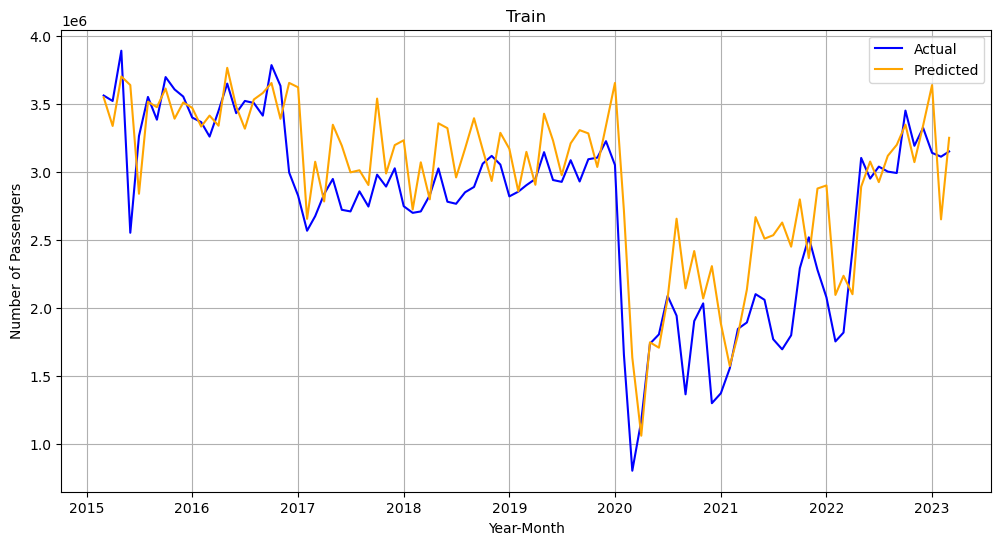

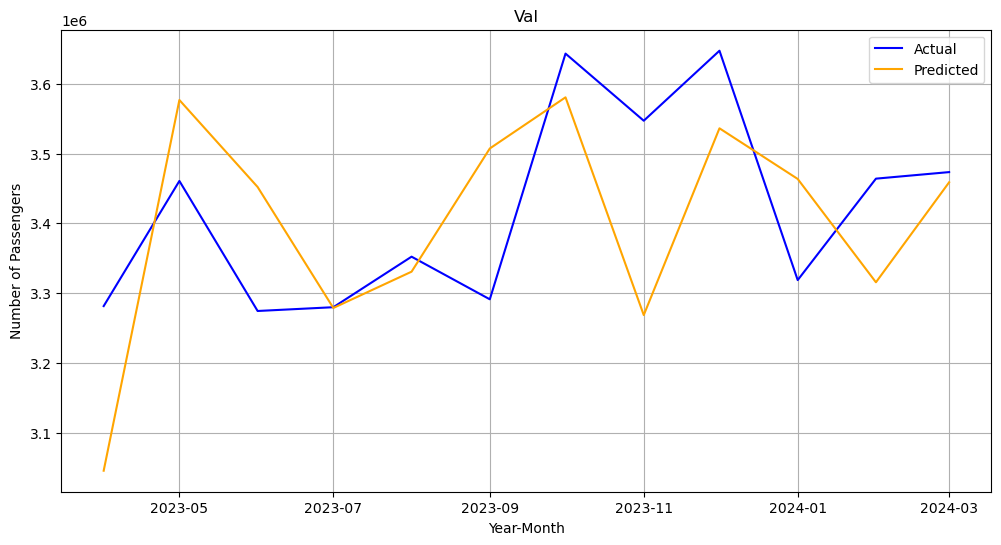

In [46]:
rnn_results = {
    'train_metrics': {
        'r_squared': train_r_squared,
        'mae': train_mae,
        'mse': train_mse,
        'mape': train_mape
    },
    'val_metrics': {
        'r_squared': val_r_squared,
        'mae': val_mae,
        'mse': val_mse,
        'mape': val_mape
    }
}

print('RNN(Train):')
print(f"R-squared: {rnn_results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {rnn_results['train_metrics']['mae']:.2f}")
print(f"MSE: {rnn_results['train_metrics']['mse']:.2f}")
print(f"MAPE: {rnn_results['train_metrics']['mape']:.2f}%")
print()
print('RNN(Val):')
print(f"R-squared: {rnn_results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {rnn_results['val_metrics']['mae']:.2f}")
print(f"MSE: {rnn_results['val_metrics']['mse']:.2f}")
print(f"MAPE: {rnn_results['val_metrics']['mape']:.2f}%")

plot_results(train_data, val_data, Y_train_rnn, Y_train_pred_rnn, Y_val_rnn, Y_val_pred_rnn)

# 모델 평가

In [50]:
models = ['RandomForest', 'XGBoost', 'LightGBM', 'LSTM', 'GRU', 'CNN', 'RNN']
 
val_mae = [
    rf_results['val_metrics']['mae'],
    xgb_results['val_metrics']['mae'],
    lgb_results['val_metrics']['mae'],
    lstm_results['val_metrics']['mae'],
    gru_results['val_metrics']['mae'],
    cnn_results['val_metrics']['mae'],
    rnn_results['val_metrics']['mae']
]

val_mse = [
    rf_results['val_metrics']['mse'],
    xgb_results['val_metrics']['mse'],
    lgb_results['val_metrics']['mse'],
    lstm_results['val_metrics']['mse'],
    gru_results['val_metrics']['mse'],
    cnn_results['val_metrics']['mse'],
    rnn_results['val_metrics']['mse']
]

val_mape = [
    rf_results['val_metrics']['mape'],
    xgb_results['val_metrics']['mape'],
    lgb_results['val_metrics']['mape'],
    lstm_results['val_metrics']['mape'],
    gru_results['val_metrics']['mape'],
    cnn_results['val_metrics']['mape'],
    rnn_results['val_metrics']['mape']
]

data = {
    'Model': models,
    'MAE': val_mae,
    'MSE': val_mse,
    'MAPE': val_mape
}

df = pd.DataFrame(data)

# MAPE를 기준으로 정렬
df_sorted = df.sort_values(by='MAPE')

# 결과 출력
display.display(df_sorted)

,Model,MAE,MSE,MAPE
1,XGBoost,83697.937500,1.369512e+10,2.483931
2,LightGBM,130092.197474,2.584648e+10,3.794834
0,RandomForest,139983.877076,2.564400e+10,4.083258
3,LSTM,157726.194444,3.813215e+10,4.492497
6,RNN,157726.194444,3.813215e+10,4.492497
4,GRU,370798.305556,1.459425e+11,10.693121
5,CNN,470574.111111,2.417929e+11,13.587613


# Test(2024년4월~2025년12월)

In [58]:
# 한국 공휴일 설정
kr_holidays = holidays.KR()

# 명절 날짜 설정
seollal_dates = pd.to_datetime(['2024-02-10', '2025-01-29'])
chuseok_dates = pd.to_datetime(['2024-09-17', '2025-10-06'])

# 명절 연휴 포함 (설날, 설날 전날, 설날 다음날 / 추석, 추석 전날, 추석 다음날)
seollal_holidays = seollal_dates.union(seollal_dates - timedelta(days=1)).union(seollal_dates + timedelta(days=1))
chuseok_holidays = chuseok_dates.union(chuseok_dates - timedelta(days=1)).union(chuseok_dates + timedelta(days=1))

def is_holiday(date):
    return date in kr_holidays

def is_festival(date):
    return date in seollal_holidays or date in chuseok_holidays

# 2024년 4월부터 2025년 12월까지의 날짜 범위 설정
start_date = '2024-04-01'
end_date = '2025-12-31'
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
date_info = pd.DataFrame(all_dates, columns=['운행일자'])

# 각 날짜에 대한 정보 생성
date_info['요일'] = date_info['운행일자'].dt.weekday
date_info['주말여부'] = date_info['요일'].apply(lambda x: '주말' if x in [5, 6] else '주중')  # 토, 일은 주말로 설정
date_info['공휴일여부'] = date_info['운행일자'].apply(lambda x: '공휴일' if is_holiday(x) else '평일')
date_info['명절여부'] = date_info['운행일자'].apply(lambda x: '명절' if is_festival(x) else '비명절')
date_info['운행년월'] = date_info['운행일자'].dt.to_period('M')

# 월별 집계
monthly_info = date_info.groupby('운행년월').agg({
    '주말여부': lambda x: (x == '주말').sum(),
    '공휴일여부': lambda x: (x == '공휴일').sum(),
    '명절여부': lambda x: (x == '명절').sum(),
    '요일': 'count'  # 총 일수 계산
}).rename(columns={'주말여부': '주말수', '공휴일여부': '공휴일수', '명절여부': '명절수', '요일': '총일수'}).reset_index()

# '평일수' 계산
monthly_info['평일수'] = monthly_info['총일수'] - monthly_info['주말수']

# 불필요한 열 삭제
monthly_info.drop(columns=['총일수'], inplace=True)

def preprocess_test_data(file_path, scaler, start_date='2024-04-01', end_date='2025-12-31'):
    df = pd.read_excel(file_path)
    df_gbline = df[df['주운행선'] == '경부선'].copy()
    df_gbline['운행년월'] = pd.to_datetime(df_gbline['운행년월'], format='%Y-%m')
    test_data = df_gbline[(df_gbline['운행년월'] >= start_date) & (df_gbline['운행년월'] <= end_date)]
    test_data['승차인원수_T1'] = test_data['승차인원수'].shift(1)
    test_data['승차인원수_T2'] = test_data['승차인원수'].shift(2)
    test_data.dropna(subset=['승차인원수_T1', '승차인원수_T2'], inplace=True)

    # 월별 정보를 테스트 데이터에 추가
    test_data['운행년월'] = test_data['운행년월'].dt.to_period('M')
    test_data = test_data.merge(monthly_info, left_on='운행년월', right_on='운행년월', how='left')

    features = ['VKOSPI', '공휴일수', '평일수', '주말수', '명절수', '승차인원수_T1', '승차인원수_T2']
    X_test = test_data[features].dropna()
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    return X_test_scaled, test_data

In [59]:
def fill_missing_vkospi(df):
    # 운행년월을 연-월 형식으로 변환
    df['운행년월'] = df['운행년월'].apply(lambda x: pd.Period(x, freq='M'))
    # VKOSPI 값이 비어 있는 경우, 작년 같은 월의 값을 채워넣기
    for idx, row in df.iterrows():
        if pd.isna(row['VKOSPI']):
            last_year = row['운행년월'] - 1  # 작년 같은 월
            same_month_last_year = df[df['운행년월'] == last_year]
            if not same_month_last_year.empty:
                df.at[idx, 'VKOSPI'] = same_month_last_year['VKOSPI'].values[0]
    return df


In [60]:
def fill_missing_values(df, columns):
    # 운행년월을 연-월 형식으로 변환
    df['운행년월'] = df['운행년월'].apply(lambda x: pd.Period(x, freq='M'))
    for column in columns:
        for idx, row in df.iterrows():
            if pd.isna(row[column]):
                last_year = row['운행년월'] - 1  # 작년 같은 월
                same_month_last_year = df[df['운행년월'] == last_year]
                if not same_month_last_year.empty:
                    df.at[idx, column] = same_month_last_year[column].values[0]
    return df


In [64]:
import pandas as pd
import numpy as np
import holidays
from datetime import timedelta

# 한국 공휴일 설정
kr_holidays = holidays.KR()

# 명절 날짜 설정
seollal_dates = pd.to_datetime(['2024-02-10', '2025-01-29'])
chuseok_dates = pd.to_datetime(['2024-09-17', '2025-10-06'])

# 명절 연휴 포함 (설날, 설날 전날, 설날 다음날 / 추석, 추석 전날, 추석 다음날)
seollal_holidays = seollal_dates.union(seollal_dates - timedelta(days=1)).union(seollal_dates + timedelta(days=1))
chuseok_holidays = chuseok_dates.union(chuseok_dates - timedelta(days=1)).union(chuseok_dates + timedelta(days=1))

def is_holiday(date):
    return date in kr_holidays

def is_festival(date):
    return date in seollal_holidays or date in chuseok_holidays

# 2024년 4월부터 2025년 12월까지의 날짜 범위 설정
start_date = '2024-04-01'
end_date = '2025-12-31'
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
date_info = pd.DataFrame(all_dates, columns=['운행일자'])

# 각 날짜에 대한 정보 생성
date_info['요일'] = date_info['운행일자'].dt.weekday
date_info['주말여부'] = date_info['요일'].apply(lambda x: '주말' if x in [5, 6] else '주중')  # 토, 일은 주말로 설정
date_info['공휴일여부'] = date_info['운행일자'].apply(lambda x: '공휴일' if is_holiday(x) else '평일')
date_info['명절여부'] = date_info['운행일자'].apply(lambda x: '명절' if is_festival(x) else '비명절')
date_info['운행년월'] = date_info['운행일자'].dt.to_period('M')

# 월별 집계
monthly_info = date_info.groupby('운행년월').agg({
    '주말여부': lambda x: (x == '주말').sum(),
    '공휴일여부': lambda x: (x == '공휴일').sum(),
    '명절여부': lambda x: (x == '명절').sum(),
    '요일': 'count'  # 총 일수 계산
}).rename(columns={'주말여부': '주말수', '공휴일여부': '공휴일수', '명절여부': '명절수', '요일': '총일수'}).reset_index()

# '평일수' 계산
monthly_info['평일수'] = monthly_info['총일수'] - monthly_info['주말수']

# '운행년월' 열을 Period 형식으로 변환
monthly_info['운행년월'] = monthly_info['운행년월'].apply(lambda x: pd.Period(x, freq='M'))

def fill_missing_values(df, columns):
    df['운행년월'] = df['운행년월'].apply(lambda x: pd.Period(x, freq='M'))
    for column in columns:
        for idx, row in df.iterrows():
            if pd.isna(row[column]):
                last_year = row['운행년월'] - 1  # 작년 같은 월
                same_month_last_year = df[df['운행년월'] == last_year]
                if not same_month_last_year.empty:
                    df.at[idx, column] = same_month_last_year[column].values[0]
    return df

def preprocess_test_data(file_path, start_date='2024-04-01', end_date='2025-12-31'):
    df = pd.read_excel(file_path)
    df_gbline = df[df['주운행선'] == '경부선'].copy()
    df_gbline['운행년월'] = pd.to_datetime(df_gbline['운행년월'], format='%Y-%m').dt.to_period('M')
    test_data = df_gbline[(df_gbline['운행년월'] >= start_date) & (df_gbline['운행년월'] <= end_date)]
    test_data['승차인원수_T1'] = test_data['승차인원수'].shift(1)
    test_data['승차인원수_T2'] = test_data['승차인원수'].shift(2)
    test_data.dropna(subset=['승차인원수_T1', '승차인원수_T2'], inplace=True)

    # VKOSPI 값 및 승차인원수_T1, 승차인원수_T2 값 채우기
    test_data = fill_missing_values(test_data, ['VKOSPI', '승차인원수_T1', '승차인원수_T2'])

    # 월별 정보를 테스트 데이터에 추가
    test_data = test_data.merge(monthly_info, left_on='운행년월', right_on='운행년월', how='left')

    features = ['VKOSPI', '공휴일수', '평일수', '주말수', '명절수', '승차인원수_T1', '승차인원수_T2']
    X_test = test_data[features].dropna()

    return X_test, test_data

file_path = r"C:\Users\james\DATA_LAB\KTX_Forecasting\data\ktx_20240720.xlsx"
df = pd.read_excel(file_path)

X_test, test_data = preprocess_test_data(file_path)

# 전처리된 데이터 확인
print(X_test.head())
print(test_data.head())


KeyError: "['공휴일수', '평일수', '주말수', '명절수'] not in index"